In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import PIL

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cross_validation import train_test_split

%matplotlib inline

/Users/aleksey/anaconda3/envs/learning/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Data preprocessing

In [2]:
df = pd.read_csv('./train.csv')
df = df.drop('PassengerId', 1)
df = df.drop('Name', 1)
df = df.drop('Ticket', 1)
df = df.drop('Cabin', 1)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [3]:
encode_features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
for enc in encode_features:
    one_hot = pd.get_dummies(df[enc], prefix=enc)
    df = df.drop(enc,axis = 1)
    df = df.join(one_hot)
df.head()

,Survived,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,SibSp_0,SibSp_1,...,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_C,Embarked_Q,Embarked_S
0,0,22.0,7.2500,0,0,1,0,1,0,1,...,1,0,0,0,0,0,0,0,0,1
1,1,38.0,71.2833,1,0,0,1,0,0,1,...,1,0,0,0,0,0,0,1,0,0
2,1,26.0,7.9250,0,0,1,1,0,1,0,...,1,0,0,0,0,0,0,0,0,1
3,1,35.0,53.1000,1,0,0,1,0,0,1,...,1,0,0,0,0,0,0,0,0,1
4,0,35.0,8.0500,0,0,1,0,1,1,0,...,1,0,0,0,0,0,0,0,0,1


In [4]:
df.describe()

,Survived,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,SibSp_0,SibSp_1,...,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_C,Embarked_Q,Embarked_S
count,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,...,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,29.699118,32.204208,0.242424,0.206510,0.551066,0.352413,0.647587,0.682379,0.234568,...,0.760943,0.132435,0.089787,0.005612,0.004489,0.005612,0.001122,0.188552,0.086420,0.722783
std,0.486592,14.526497,49.693429,0.428790,0.405028,0.497665,0.477990,0.477990,0.465813,0.423966,...,0.426747,0.339154,0.286037,0.074743,0.066890,0.074743,0.033501,0.391372,0.281141,0.447876
min,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.125000,7.910400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,28.000000,14.454200,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,38.000000,31.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,80.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
real_features = ['Age', 'Fare']
cat_features = list(set(df.columns.values.tolist()) - set(real_features) )
cat_features.remove('Survived')
print (cat_features)

['Parch_0', 'Embarked_S', 'Embarked_Q', 'SibSp_3', 'Parch_6', 'Parch_3', 'Parch_5', 'SibSp_2', 'Embarked_C', 'Parch_2', 'Parch_4', 'SibSp_4', 'SibSp_0', 'SibSp_1', 'Sex_male', 'Pclass_2', 'Pclass_3', 'SibSp_5', 'Sex_female', 'Pclass_1', 'Parch_1', 'SibSp_8']


In [6]:
print (df.shape)

(891, 25)


In [7]:
df['Age'] = df['Age'].fillna(0)

In [8]:
y = df['Survived'].to_numpy()
df = df.drop('Survived', 1)

X_real = df[real_features].to_numpy()
X_cat = df[cat_features].to_numpy()

print ("X_real: {} ".format(X_real[0]))
print ("X_cat: {} ".format(X_cat[0]))
print ("y: {} ".format(y[0]))

X_real: [22.    7.25] 
X_cat: [1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0] 
y: 0 


In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_real_scaled = scaler.fit_transform(X_real)

In [10]:
(X_train_real, X_test_real, X_train_cat, X_test_cat, 
 y_train, y_test)= train_test_split(X_real_scaled, X_cat, y, test_size=0.1, random_state=0)
print (X_train_real.shape, X_test_real.shape)
print (X_train_cat.shape, X_test_cat.shape)

(801, 2) (90, 2)
(801, 22) (90, 22)


In [11]:
selected_features = (0, 1, 2, 5, 7, 9, 10, 12, 14, 16, 17, 18, 19, 21, 22)

In [12]:
X_train = np.hstack((X_train_real, X_train_cat))
X_test = np.hstack((X_test_real, X_test_cat))

X_train = X_train[:,selected_features]
X_test = X_test[:,selected_features]

X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

print (X_train.shape, X_test.shape)

torch.Size([801, 15]) torch.Size([90, 15])


## Neural network

In [13]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.ReLU):
        super(FullyConnected, self).__init__()
        layers = []
        
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout())
            layers.append(activation_fn())
        else: # нам не нужен дропаут и фнкция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
            layers.append(nn.Sigmoid())
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [14]:
def output_vals(output):
    vals = []
    for out in output:
        out = out.item()
        if out >= 0.5:
            vals.append(1)
        else:
            vals.append(0)   
    return vals        

def correct_vals(output, target):    
    vals = torch.Tensor(output_vals(output))
    correct = (vals == target).sum().item()         
    return correct

In [15]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(Net, self).__init__()
               
        self.fc = FullyConnected([15, 32, 1], dropout=dropout)
        
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        self.criterion = nn.BCELoss()
           
    def forward(self, x):        
        out = self.fc(x)
        return out.squeeze(1)
    
    def loss(self, output, target, **kwargs):          
        self._loss = self.criterion(output, target)
        self._correct = correct_vals(output, target)   
        
        return self._loss

In [16]:
def train(epoch, models, log=None):
    train_size = len(X_train)
    for batch_idx, (data, target) in enumerate(loader(X_train, y_train)):
        for model in models.values():                             
            model.optim.zero_grad()            
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / train_size)
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / train_size)
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._correct))
        print(line + losses)

In [17]:
def test(models, log=None):
    test_size = len(X_test)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader(X_test, y_test):
            output = {k: m(data) for k, m in models.items()}           
            for k, m in models.items():     
                #print (output[k].shape, target.shape)
                test_loss[k] += m.loss(output[k], target, size_average=False).item() # sum up batch loss                
                correct[k] += correct_vals(output[k], target)
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: c / test_size for k, c in correct.items()}
    lines = '\n'.join([line(k, test_loss[k], correct[k], 100*correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [18]:
def plot_graphs(log, tpe='loss'):
    keys = log.keys()
    logs = {k:[z for z in zip(*log[k])] for k in keys}
    epochs = {k:range(len(log[k])) for k in keys}
 
    
    if tpe == 'loss':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][0], label=k) for k in keys])
        plt.title('errors')
        plt.xlabel('epoch')
        plt.ylabel('error')
        plt.legend(handles=handlers)
        plt.show()
    elif tpe == 'accuracy':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][1], label=k) for k in log.keys()])
        plt.title('accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(handles=handlers)
        plt.show()

In [19]:
def loader(x, y, batch_size=16):    
    for i in range(0, x.shape[0] - 1, batch_size):
        data = x[i:i+batch_size]
        if data.shape[0] == batch_size:            
            targets = y[i:i+batch_size]

            yield data, targets

In [20]:
models = {'bn': Net(True), 'drop': Net(False, True), 'plain': Net()}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

print (models['bn'])

Net(
  (fc): FullyConnected(
    (model): Sequential(
      (0): Linear(in_features=15, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=1, bias=True)
      (3): Sigmoid()
    )
  )
  (criterion): BCELoss()
)


In [21]:
for epoch in range(1, 501):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, test_log)

Train Epoch: 1 [0/801 (0%)]	Losses bn: 0.670982 drop: 0.732536 plain: 0.726693
Train Epoch: 1 [800/801 (6%)]	Losses bn: 0.684073 drop: 0.698222 plain: 0.689076
Test set:
bn: Loss: 0.0373	Accuracy: 57.0/90 (63%)
drop: Loss: 0.0388	Accuracy: 34.0/90 (38%)
plain: Loss: 0.0384	Accuracy: 45.0/90 (50%)

Train Epoch: 2 [0/801 (0%)]	Losses bn: 0.662622 drop: 0.727876 plain: 0.712593
Train Epoch: 2 [800/801 (6%)]	Losses bn: 0.686947 drop: 0.687601 plain: 0.691785
Test set:
bn: Loss: 0.0370	Accuracy: 56.0/90 (62%)
drop: Loss: 0.0384	Accuracy: 43.0/90 (48%)
plain: Loss: 0.0379	Accuracy: 46.0/90 (51%)

Train Epoch: 3 [0/801 (0%)]	Losses bn: 0.654964 drop: 0.697535 plain: 0.700224
Train Epoch: 3 [800/801 (6%)]	Losses bn: 0.689882 drop: 0.679175 plain: 0.694657
Test set:
bn: Loss: 0.0366	Accuracy: 56.0/90 (62%)
drop: Loss: 0.0381	Accuracy: 48.0/90 (53%)
plain: Loss: 0.0375	Accuracy: 47.0/90 (52%)

Train Epoch: 4 [0/801 (0%)]	Losses bn: 0.647411 drop: 0.693717 plain: 0.688941
Train Epoch: 4 [800/801 

Train Epoch: 30 [800/801 (6%)]	Losses bn: 0.712704 drop: 0.679083 plain: 0.711027
Test set:
bn: Loss: 0.0298	Accuracy: 58.0/90 (64%)
drop: Loss: 0.0324	Accuracy: 58.0/90 (64%)
plain: Loss: 0.0303	Accuracy: 59.0/90 (66%)

Train Epoch: 31 [0/801 (0%)]	Losses bn: 0.488117 drop: 0.540485 plain: 0.517832
Train Epoch: 31 [800/801 (6%)]	Losses bn: 0.710609 drop: 0.712649 plain: 0.708696
Test set:
bn: Loss: 0.0296	Accuracy: 59.0/90 (66%)
drop: Loss: 0.0322	Accuracy: 59.0/90 (66%)
plain: Loss: 0.0301	Accuracy: 59.0/90 (66%)

Train Epoch: 32 [0/801 (0%)]	Losses bn: 0.484381 drop: 0.611379 plain: 0.513480
Train Epoch: 32 [800/801 (6%)]	Losses bn: 0.708399 drop: 0.714533 plain: 0.706375
Test set:
bn: Loss: 0.0294	Accuracy: 59.0/90 (66%)
drop: Loss: 0.0320	Accuracy: 59.0/90 (66%)
plain: Loss: 0.0299	Accuracy: 59.0/90 (66%)

Train Epoch: 33 [0/801 (0%)]	Losses bn: 0.480753 drop: 0.551018 plain: 0.509184
Train Epoch: 33 [800/801 (6%)]	Losses bn: 0.706131 drop: 0.683105 plain: 0.704019
Test set:
bn: L

Train Epoch: 58 [800/801 (6%)]	Losses bn: 0.639762 drop: 0.688012 plain: 0.650785
Test set:
bn: Loss: 0.0254	Accuracy: 65.0/90 (72%)
drop: Loss: 0.0280	Accuracy: 62.0/90 (69%)
plain: Loss: 0.0256	Accuracy: 63.0/90 (70%)

Train Epoch: 59 [0/801 (0%)]	Losses bn: 0.410697 drop: 0.487073 plain: 0.422286
Train Epoch: 59 [800/801 (6%)]	Losses bn: 0.637453 drop: 0.676386 plain: 0.648950
Test set:
bn: Loss: 0.0253	Accuracy: 65.0/90 (72%)
drop: Loss: 0.0279	Accuracy: 62.0/90 (69%)
plain: Loss: 0.0255	Accuracy: 64.0/90 (71%)

Train Epoch: 60 [0/801 (0%)]	Losses bn: 0.408769 drop: 0.481253 plain: 0.419878
Train Epoch: 60 [800/801 (6%)]	Losses bn: 0.635184 drop: 0.626632 plain: 0.647176
Test set:
bn: Loss: 0.0252	Accuracy: 65.0/90 (72%)
drop: Loss: 0.0278	Accuracy: 62.0/90 (69%)
plain: Loss: 0.0254	Accuracy: 64.0/90 (71%)

Train Epoch: 61 [0/801 (0%)]	Losses bn: 0.406889 drop: 0.490408 plain: 0.417533
Train Epoch: 61 [800/801 (6%)]	Losses bn: 0.632970 drop: 0.663182 plain: 0.645422
Test set:
bn: L

Train Epoch: 86 [800/801 (6%)]	Losses bn: 0.589079 drop: 0.621321 plain: 0.609226
Test set:
bn: Loss: 0.0229	Accuracy: 66.0/90 (73%)
drop: Loss: 0.0250	Accuracy: 65.0/90 (72%)
plain: Loss: 0.0230	Accuracy: 67.0/90 (74%)

Train Epoch: 87 [0/801 (0%)]	Losses bn: 0.367129 drop: 0.433357 plain: 0.374759
Train Epoch: 87 [800/801 (6%)]	Losses bn: 0.587588 drop: 0.539765 plain: 0.607998
Test set:
bn: Loss: 0.0228	Accuracy: 66.0/90 (73%)
drop: Loss: 0.0249	Accuracy: 65.0/90 (72%)
plain: Loss: 0.0230	Accuracy: 67.0/90 (74%)

Train Epoch: 88 [0/801 (0%)]	Losses bn: 0.366020 drop: 0.435199 plain: 0.373657
Train Epoch: 88 [800/801 (6%)]	Losses bn: 0.586137 drop: 0.661701 plain: 0.606812
Test set:
bn: Loss: 0.0228	Accuracy: 66.0/90 (73%)
drop: Loss: 0.0248	Accuracy: 64.0/90 (71%)
plain: Loss: 0.0229	Accuracy: 67.0/90 (74%)

Train Epoch: 89 [0/801 (0%)]	Losses bn: 0.364941 drop: 0.425853 plain: 0.372583
Train Epoch: 89 [800/801 (6%)]	Losses bn: 0.584704 drop: 0.613929 plain: 0.605615
Test set:
bn: L

Train Epoch: 114 [800/801 (6%)]	Losses bn: 0.553783 drop: 0.619754 plain: 0.580172
Test set:
bn: Loss: 0.0215	Accuracy: 65.0/90 (72%)
drop: Loss: 0.0230	Accuracy: 67.0/90 (74%)
plain: Loss: 0.0216	Accuracy: 67.0/90 (74%)

Train Epoch: 115 [0/801 (0%)]	Losses bn: 0.342519 drop: 0.412064 plain: 0.352451
Train Epoch: 115 [800/801 (6%)]	Losses bn: 0.552794 drop: 0.523245 plain: 0.579269
Test set:
bn: Loss: 0.0215	Accuracy: 65.0/90 (72%)
drop: Loss: 0.0229	Accuracy: 68.0/90 (76%)
plain: Loss: 0.0215	Accuracy: 67.0/90 (74%)

Train Epoch: 116 [0/801 (0%)]	Losses bn: 0.341797 drop: 0.428942 plain: 0.351890
Train Epoch: 116 [800/801 (6%)]	Losses bn: 0.551823 drop: 0.618438 plain: 0.578373
Test set:
bn: Loss: 0.0214	Accuracy: 65.0/90 (72%)
drop: Loss: 0.0229	Accuracy: 68.0/90 (76%)
plain: Loss: 0.0215	Accuracy: 66.0/90 (73%)

Train Epoch: 117 [0/801 (0%)]	Losses bn: 0.341078 drop: 0.407198 plain: 0.351348
Train Epoch: 117 [800/801 (6%)]	Losses bn: 0.550878 drop: 0.606792 plain: 0.577511
Test set

Train Epoch: 142 [800/801 (6%)]	Losses bn: 0.531513 drop: 0.524598 plain: 0.558190
Test set:
bn: Loss: 0.0207	Accuracy: 66.0/90 (73%)
drop: Loss: 0.0218	Accuracy: 67.0/90 (74%)
plain: Loss: 0.0207	Accuracy: 66.0/90 (73%)

Train Epoch: 143 [0/801 (0%)]	Losses bn: 0.324998 drop: 0.395426 plain: 0.340191
Train Epoch: 143 [800/801 (6%)]	Losses bn: 0.530884 drop: 0.536953 plain: 0.557529
Test set:
bn: Loss: 0.0207	Accuracy: 66.0/90 (73%)
drop: Loss: 0.0217	Accuracy: 67.0/90 (74%)
plain: Loss: 0.0207	Accuracy: 66.0/90 (73%)

Train Epoch: 144 [0/801 (0%)]	Losses bn: 0.324478 drop: 0.347858 plain: 0.339859
Train Epoch: 144 [800/801 (6%)]	Losses bn: 0.530256 drop: 0.543188 plain: 0.556886
Test set:
bn: Loss: 0.0206	Accuracy: 66.0/90 (73%)
drop: Loss: 0.0217	Accuracy: 67.0/90 (74%)
plain: Loss: 0.0207	Accuracy: 66.0/90 (73%)

Train Epoch: 145 [0/801 (0%)]	Losses bn: 0.323963 drop: 0.391661 plain: 0.339518
Train Epoch: 145 [800/801 (6%)]	Losses bn: 0.529647 drop: 0.491959 plain: 0.556223
Test set

Train Epoch: 170 [800/801 (6%)]	Losses bn: 0.516429 drop: 0.519250 plain: 0.541501
Test set:
bn: Loss: 0.0203	Accuracy: 67.0/90 (74%)
drop: Loss: 0.0210	Accuracy: 68.0/90 (76%)
plain: Loss: 0.0202	Accuracy: 67.0/90 (74%)

Train Epoch: 171 [0/801 (0%)]	Losses bn: 0.312757 drop: 0.349968 plain: 0.331128
Train Epoch: 171 [800/801 (6%)]	Losses bn: 0.515957 drop: 0.528040 plain: 0.540888
Test set:
bn: Loss: 0.0203	Accuracy: 67.0/90 (74%)
drop: Loss: 0.0210	Accuracy: 68.0/90 (76%)
plain: Loss: 0.0202	Accuracy: 67.0/90 (74%)

Train Epoch: 172 [0/801 (0%)]	Losses bn: 0.312401 drop: 0.373999 plain: 0.330839
Train Epoch: 172 [800/801 (6%)]	Losses bn: 0.515491 drop: 0.588139 plain: 0.540300
Test set:
bn: Loss: 0.0202	Accuracy: 67.0/90 (74%)
drop: Loss: 0.0210	Accuracy: 68.0/90 (76%)
plain: Loss: 0.0202	Accuracy: 67.0/90 (74%)

Train Epoch: 173 [0/801 (0%)]	Losses bn: 0.312049 drop: 0.322967 plain: 0.330543
Train Epoch: 173 [800/801 (6%)]	Losses bn: 0.515020 drop: 0.587799 plain: 0.539713
Test set

Train Epoch: 198 [800/801 (6%)]	Losses bn: 0.505538 drop: 0.548498 plain: 0.526825
Test set:
bn: Loss: 0.0200	Accuracy: 67.0/90 (74%)
drop: Loss: 0.0205	Accuracy: 68.0/90 (76%)
plain: Loss: 0.0199	Accuracy: 68.0/90 (76%)

Train Epoch: 199 [0/801 (0%)]	Losses bn: 0.303778 drop: 0.356661 plain: 0.323346
Train Epoch: 199 [800/801 (6%)]	Losses bn: 0.505199 drop: 0.650412 plain: 0.526401
Test set:
bn: Loss: 0.0200	Accuracy: 67.0/90 (74%)
drop: Loss: 0.0205	Accuracy: 68.0/90 (76%)
plain: Loss: 0.0199	Accuracy: 68.0/90 (76%)

Train Epoch: 200 [0/801 (0%)]	Losses bn: 0.303491 drop: 0.372240 plain: 0.323064
Train Epoch: 200 [800/801 (6%)]	Losses bn: 0.504880 drop: 0.445878 plain: 0.525975
Test set:
bn: Loss: 0.0200	Accuracy: 67.0/90 (74%)
drop: Loss: 0.0205	Accuracy: 68.0/90 (76%)
plain: Loss: 0.0198	Accuracy: 68.0/90 (76%)

Train Epoch: 201 [0/801 (0%)]	Losses bn: 0.303195 drop: 0.370690 plain: 0.322805
Train Epoch: 201 [800/801 (6%)]	Losses bn: 0.504556 drop: 0.502377 plain: 0.525554
Test set

Train Epoch: 226 [800/801 (6%)]	Losses bn: 0.497111 drop: 0.569493 plain: 0.516382
Test set:
bn: Loss: 0.0198	Accuracy: 67.0/90 (74%)
drop: Loss: 0.0202	Accuracy: 68.0/90 (76%)
plain: Loss: 0.0197	Accuracy: 68.0/90 (76%)

Train Epoch: 227 [0/801 (0%)]	Losses bn: 0.296688 drop: 0.299990 plain: 0.316064
Train Epoch: 227 [800/801 (6%)]	Losses bn: 0.496825 drop: 0.557415 plain: 0.516027
Test set:
bn: Loss: 0.0198	Accuracy: 67.0/90 (74%)
drop: Loss: 0.0202	Accuracy: 67.0/90 (74%)
plain: Loss: 0.0196	Accuracy: 68.0/90 (76%)

Train Epoch: 228 [0/801 (0%)]	Losses bn: 0.296435 drop: 0.325721 plain: 0.315801
Train Epoch: 228 [800/801 (6%)]	Losses bn: 0.496555 drop: 0.556035 plain: 0.515680
Test set:
bn: Loss: 0.0198	Accuracy: 66.0/90 (73%)
drop: Loss: 0.0202	Accuracy: 67.0/90 (74%)
plain: Loss: 0.0196	Accuracy: 68.0/90 (76%)

Train Epoch: 229 [0/801 (0%)]	Losses bn: 0.296176 drop: 0.393658 plain: 0.315535
Train Epoch: 229 [800/801 (6%)]	Losses bn: 0.496260 drop: 0.604514 plain: 0.515323
Test set

Train Epoch: 254 [800/801 (6%)]	Losses bn: 0.489901 drop: 0.553583 plain: 0.508067
Test set:
bn: Loss: 0.0198	Accuracy: 66.0/90 (73%)
drop: Loss: 0.0199	Accuracy: 68.0/90 (76%)
plain: Loss: 0.0195	Accuracy: 67.0/90 (74%)

Train Epoch: 255 [0/801 (0%)]	Losses bn: 0.290862 drop: 0.303735 plain: 0.309399
Train Epoch: 255 [800/801 (6%)]	Losses bn: 0.489664 drop: 0.593853 plain: 0.507829
Test set:
bn: Loss: 0.0198	Accuracy: 66.0/90 (73%)
drop: Loss: 0.0199	Accuracy: 68.0/90 (76%)
plain: Loss: 0.0195	Accuracy: 67.0/90 (74%)

Train Epoch: 256 [0/801 (0%)]	Losses bn: 0.290715 drop: 0.297000 plain: 0.309190
Train Epoch: 256 [800/801 (6%)]	Losses bn: 0.489455 drop: 0.598621 plain: 0.507578
Test set:
bn: Loss: 0.0198	Accuracy: 66.0/90 (73%)
drop: Loss: 0.0199	Accuracy: 68.0/90 (76%)
plain: Loss: 0.0195	Accuracy: 67.0/90 (74%)

Train Epoch: 257 [0/801 (0%)]	Losses bn: 0.290551 drop: 0.392351 plain: 0.308972
Train Epoch: 257 [800/801 (6%)]	Losses bn: 0.489226 drop: 0.626176 plain: 0.507349
Test set

Train Epoch: 282 [800/801 (6%)]	Losses bn: 0.483998 drop: 0.553841 plain: 0.501419
Test set:
bn: Loss: 0.0197	Accuracy: 66.0/90 (73%)
drop: Loss: 0.0197	Accuracy: 67.0/90 (74%)
plain: Loss: 0.0194	Accuracy: 68.0/90 (76%)

Train Epoch: 283 [0/801 (0%)]	Losses bn: 0.286319 drop: 0.329720 plain: 0.303592
Train Epoch: 283 [800/801 (6%)]	Losses bn: 0.483832 drop: 0.480130 plain: 0.501223
Test set:
bn: Loss: 0.0197	Accuracy: 66.0/90 (73%)
drop: Loss: 0.0197	Accuracy: 67.0/90 (74%)
plain: Loss: 0.0194	Accuracy: 68.0/90 (76%)

Train Epoch: 284 [0/801 (0%)]	Losses bn: 0.286192 drop: 0.317067 plain: 0.303414
Train Epoch: 284 [800/801 (6%)]	Losses bn: 0.483633 drop: 0.503104 plain: 0.501006
Test set:
bn: Loss: 0.0197	Accuracy: 66.0/90 (73%)
drop: Loss: 0.0197	Accuracy: 67.0/90 (74%)
plain: Loss: 0.0194	Accuracy: 68.0/90 (76%)

Train Epoch: 285 [0/801 (0%)]	Losses bn: 0.286030 drop: 0.335315 plain: 0.303229
Train Epoch: 285 [800/801 (6%)]	Losses bn: 0.483435 drop: 0.564781 plain: 0.500807
Test set

Train Epoch: 310 [800/801 (6%)]	Losses bn: 0.479513 drop: 0.525654 plain: 0.495767
Test set:
bn: Loss: 0.0197	Accuracy: 66.0/90 (73%)
drop: Loss: 0.0196	Accuracy: 66.0/90 (73%)
plain: Loss: 0.0194	Accuracy: 68.0/90 (76%)

Train Epoch: 311 [0/801 (0%)]	Losses bn: 0.282609 drop: 0.334823 plain: 0.298545
Train Epoch: 311 [800/801 (6%)]	Losses bn: 0.479325 drop: 0.447398 plain: 0.495576
Test set:
bn: Loss: 0.0197	Accuracy: 66.0/90 (73%)
drop: Loss: 0.0196	Accuracy: 66.0/90 (73%)
plain: Loss: 0.0194	Accuracy: 68.0/90 (76%)

Train Epoch: 312 [0/801 (0%)]	Losses bn: 0.282476 drop: 0.331544 plain: 0.298361
Train Epoch: 312 [800/801 (6%)]	Losses bn: 0.479158 drop: 0.598873 plain: 0.495376
Test set:
bn: Loss: 0.0197	Accuracy: 66.0/90 (73%)
drop: Loss: 0.0196	Accuracy: 66.0/90 (73%)
plain: Loss: 0.0194	Accuracy: 68.0/90 (76%)

Train Epoch: 313 [0/801 (0%)]	Losses bn: 0.282337 drop: 0.259804 plain: 0.298189
Train Epoch: 313 [800/801 (6%)]	Losses bn: 0.478974 drop: 0.553851 plain: 0.495184
Test set

Train Epoch: 338 [800/801 (6%)]	Losses bn: 0.474855 drop: 0.640385 plain: 0.490435
Test set:
bn: Loss: 0.0198	Accuracy: 65.0/90 (72%)
drop: Loss: 0.0195	Accuracy: 65.0/90 (72%)
plain: Loss: 0.0194	Accuracy: 68.0/90 (76%)

Train Epoch: 339 [0/801 (0%)]	Losses bn: 0.278651 drop: 0.339809 plain: 0.294026
Train Epoch: 339 [800/801 (6%)]	Losses bn: 0.474715 drop: 0.467453 plain: 0.490227
Test set:
bn: Loss: 0.0198	Accuracy: 65.0/90 (72%)
drop: Loss: 0.0195	Accuracy: 65.0/90 (72%)
plain: Loss: 0.0194	Accuracy: 68.0/90 (76%)

Train Epoch: 340 [0/801 (0%)]	Losses bn: 0.278544 drop: 0.335023 plain: 0.293912
Train Epoch: 340 [800/801 (6%)]	Losses bn: 0.474520 drop: 0.600585 plain: 0.490011
Test set:
bn: Loss: 0.0198	Accuracy: 65.0/90 (72%)
drop: Loss: 0.0195	Accuracy: 65.0/90 (72%)
plain: Loss: 0.0194	Accuracy: 68.0/90 (76%)

Train Epoch: 341 [0/801 (0%)]	Losses bn: 0.278432 drop: 0.325064 plain: 0.293793
Train Epoch: 341 [800/801 (6%)]	Losses bn: 0.474354 drop: 0.460519 plain: 0.489812
Test set

Train Epoch: 366 [800/801 (6%)]	Losses bn: 0.470915 drop: 0.530520 plain: 0.484572
Test set:
bn: Loss: 0.0198	Accuracy: 65.0/90 (72%)
drop: Loss: 0.0195	Accuracy: 65.0/90 (72%)
plain: Loss: 0.0194	Accuracy: 66.0/90 (73%)

Train Epoch: 367 [0/801 (0%)]	Losses bn: 0.276070 drop: 0.323348 plain: 0.289650
Train Epoch: 367 [800/801 (6%)]	Losses bn: 0.470742 drop: 0.535706 plain: 0.484398
Test set:
bn: Loss: 0.0198	Accuracy: 65.0/90 (72%)
drop: Loss: 0.0195	Accuracy: 65.0/90 (72%)
plain: Loss: 0.0194	Accuracy: 66.0/90 (73%)

Train Epoch: 368 [0/801 (0%)]	Losses bn: 0.276024 drop: 0.261146 plain: 0.289447
Train Epoch: 368 [800/801 (6%)]	Losses bn: 0.470595 drop: 0.577935 plain: 0.484185
Test set:
bn: Loss: 0.0198	Accuracy: 65.0/90 (72%)
drop: Loss: 0.0194	Accuracy: 65.0/90 (72%)
plain: Loss: 0.0194	Accuracy: 66.0/90 (73%)

Train Epoch: 369 [0/801 (0%)]	Losses bn: 0.275981 drop: 0.276368 plain: 0.289231
Train Epoch: 369 [800/801 (6%)]	Losses bn: 0.470436 drop: 0.502843 plain: 0.484003
Test set

Train Epoch: 394 [800/801 (6%)]	Losses bn: 0.465917 drop: 0.566244 plain: 0.479419
Test set:
bn: Loss: 0.0199	Accuracy: 65.0/90 (72%)
drop: Loss: 0.0195	Accuracy: 65.0/90 (72%)
plain: Loss: 0.0194	Accuracy: 66.0/90 (73%)

Train Epoch: 395 [0/801 (0%)]	Losses bn: 0.274845 drop: 0.289346 plain: 0.283843
Train Epoch: 395 [800/801 (6%)]	Losses bn: 0.465767 drop: 0.514426 plain: 0.479225
Test set:
bn: Loss: 0.0199	Accuracy: 65.0/90 (72%)
drop: Loss: 0.0195	Accuracy: 65.0/90 (72%)
plain: Loss: 0.0194	Accuracy: 66.0/90 (73%)

Train Epoch: 396 [0/801 (0%)]	Losses bn: 0.274816 drop: 0.330499 plain: 0.283667
Train Epoch: 396 [800/801 (6%)]	Losses bn: 0.465577 drop: 0.546904 plain: 0.479026
Test set:
bn: Loss: 0.0199	Accuracy: 65.0/90 (72%)
drop: Loss: 0.0195	Accuracy: 65.0/90 (72%)
plain: Loss: 0.0194	Accuracy: 66.0/90 (73%)

Train Epoch: 397 [0/801 (0%)]	Losses bn: 0.274766 drop: 0.342568 plain: 0.283509
Train Epoch: 397 [800/801 (6%)]	Losses bn: 0.465380 drop: 0.469319 plain: 0.478835
Test set

Train Epoch: 423 [800/801 (6%)]	Losses bn: 0.461123 drop: 0.522985 plain: 0.474689
Test set:
bn: Loss: 0.0199	Accuracy: 65.0/90 (72%)
drop: Loss: 0.0194	Accuracy: 65.0/90 (72%)
plain: Loss: 0.0195	Accuracy: 66.0/90 (73%)

Train Epoch: 424 [0/801 (0%)]	Losses bn: 0.273838 drop: 0.365858 plain: 0.279219
Train Epoch: 424 [800/801 (6%)]	Losses bn: 0.460989 drop: 0.514212 plain: 0.474544
Test set:
bn: Loss: 0.0199	Accuracy: 65.0/90 (72%)
drop: Loss: 0.0194	Accuracy: 65.0/90 (72%)
plain: Loss: 0.0195	Accuracy: 66.0/90 (73%)

Train Epoch: 425 [0/801 (0%)]	Losses bn: 0.273827 drop: 0.350654 plain: 0.279067
Train Epoch: 425 [800/801 (6%)]	Losses bn: 0.460851 drop: 0.444201 plain: 0.474374
Test set:
bn: Loss: 0.0199	Accuracy: 65.0/90 (72%)
drop: Loss: 0.0194	Accuracy: 65.0/90 (72%)
plain: Loss: 0.0195	Accuracy: 66.0/90 (73%)

Train Epoch: 426 [0/801 (0%)]	Losses bn: 0.273806 drop: 0.323855 plain: 0.278932
Train Epoch: 426 [800/801 (6%)]	Losses bn: 0.460739 drop: 0.501728 plain: 0.474205
Test set

Train Epoch: 451 [800/801 (6%)]	Losses bn: 0.457310 drop: 0.518038 plain: 0.470097
Test set:
bn: Loss: 0.0200	Accuracy: 65.0/90 (72%)
drop: Loss: 0.0194	Accuracy: 65.0/90 (72%)
plain: Loss: 0.0195	Accuracy: 67.0/90 (74%)

Train Epoch: 452 [0/801 (0%)]	Losses bn: 0.272393 drop: 0.390574 plain: 0.275244
Train Epoch: 452 [800/801 (6%)]	Losses bn: 0.457230 drop: 0.500650 plain: 0.469911
Test set:
bn: Loss: 0.0200	Accuracy: 65.0/90 (72%)
drop: Loss: 0.0194	Accuracy: 65.0/90 (72%)
plain: Loss: 0.0196	Accuracy: 67.0/90 (74%)

Train Epoch: 453 [0/801 (0%)]	Losses bn: 0.272314 drop: 0.349056 plain: 0.275108
Train Epoch: 453 [800/801 (6%)]	Losses bn: 0.457067 drop: 0.532686 plain: 0.469725
Test set:
bn: Loss: 0.0200	Accuracy: 65.0/90 (72%)
drop: Loss: 0.0194	Accuracy: 65.0/90 (72%)
plain: Loss: 0.0196	Accuracy: 67.0/90 (74%)

Train Epoch: 454 [0/801 (0%)]	Losses bn: 0.272254 drop: 0.377367 plain: 0.274963
Train Epoch: 454 [800/801 (6%)]	Losses bn: 0.456987 drop: 0.471871 plain: 0.469551
Test set

Train Epoch: 479 [800/801 (6%)]	Losses bn: 0.454617 drop: 0.539331 plain: 0.465668
Test set:
bn: Loss: 0.0202	Accuracy: 65.0/90 (72%)
drop: Loss: 0.0194	Accuracy: 65.0/90 (72%)
plain: Loss: 0.0197	Accuracy: 67.0/90 (74%)

Train Epoch: 480 [0/801 (0%)]	Losses bn: 0.270658 drop: 0.281414 plain: 0.271600
Train Epoch: 480 [800/801 (6%)]	Losses bn: 0.454505 drop: 0.447919 plain: 0.465543
Test set:
bn: Loss: 0.0202	Accuracy: 65.0/90 (72%)
drop: Loss: 0.0194	Accuracy: 65.0/90 (72%)
plain: Loss: 0.0197	Accuracy: 67.0/90 (74%)

Train Epoch: 481 [0/801 (0%)]	Losses bn: 0.270576 drop: 0.329618 plain: 0.271476
Train Epoch: 481 [800/801 (6%)]	Losses bn: 0.454389 drop: 0.534803 plain: 0.465420
Test set:
bn: Loss: 0.0202	Accuracy: 65.0/90 (72%)
drop: Loss: 0.0194	Accuracy: 65.0/90 (72%)
plain: Loss: 0.0197	Accuracy: 67.0/90 (74%)

Train Epoch: 482 [0/801 (0%)]	Losses bn: 0.270518 drop: 0.378093 plain: 0.271357
Train Epoch: 482 [800/801 (6%)]	Losses bn: 0.454258 drop: 0.513142 plain: 0.465293
Test set

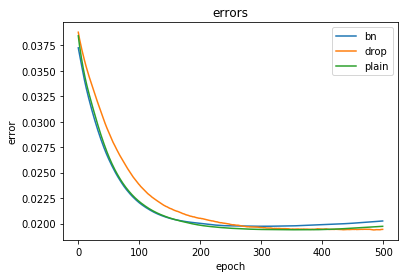

In [22]:
plot_graphs(test_log, 'loss')

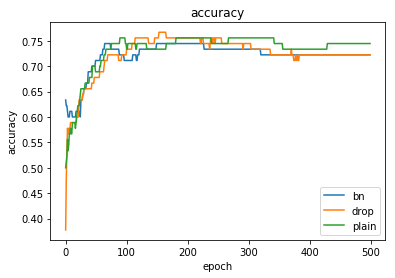

In [23]:
plot_graphs(test_log, 'accuracy')

### NN submission

In [24]:
df = pd.read_csv('./test.csv')
passenger_ids = df['PassengerId'].to_numpy()
df = df.drop('PassengerId', 1)
df = df.drop('Name', 1)
df = df.drop('Ticket', 1)
df = df.drop('Cabin', 1)
df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


In [25]:
encode_features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
for enc in encode_features:
    one_hot = pd.get_dummies(df[enc], prefix=enc)
    df = df.drop(enc,axis = 1)
    df = df.join(one_hot)
df.head()

,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,SibSp_0,SibSp_1,SibSp_2,...,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Parch_9,Embarked_C,Embarked_Q,Embarked_S
0,34.5,7.8292,0,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,47.0,7.0000,0,0,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,62.0,9.6875,0,1,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,27.0,8.6625,0,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,22.0,12.2875,0,0,1,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1


In [26]:
df.describe()

,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,SibSp_0,SibSp_1,SibSp_2,...,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Parch_9,Embarked_C,Embarked_Q,Embarked_S
count,332.000000,417.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,...,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,30.272590,35.627188,0.255981,0.222488,0.521531,0.363636,0.636364,0.677033,0.263158,0.033493,...,0.124402,0.078947,0.007177,0.004785,0.002392,0.002392,0.004785,0.244019,0.110048,0.645933
std,14.181209,55.907576,0.436934,0.416416,0.500135,0.481622,0.481622,0.468170,0.440875,0.180135,...,0.330435,0.269980,0.084514,0.069088,0.048912,0.048912,0.069088,0.430019,0.313324,0.478803
min,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21.000000,7.895800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,14.454200,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,39.000000,31.500000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,76.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [27]:
df['Age'] = df['Age'].fillna(0)
df['Fare'] = df['Fare'].fillna(0)

In [28]:
X_testing_real_zeros = df[real_features].to_numpy()
X_testing_cat_zeros = df[cat_features].to_numpy()

X_testing_real_zeros_scaled = scaler.transform(X_testing_real_zeros)

print ("X_real: {} ".format(X_testing_real_zeros[0]))
print ("X_cat: {} ".format(X_testing_cat_zeros[0]))
print ("y: {} ".format(y[0]))

X_real: [34.5     7.8292] 
X_cat: [1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0] 
y: 0 


In [29]:
print (df.shape)

(418, 25)


In [32]:
X_testing = np.hstack((X_testing_real_zeros_scaled, X_testing_cat_zeros))
X_testing = X_testing[:,selected_features]

X_testing = torch.Tensor(X_testing)

pred = models['plain'](X_testing)
predicted = output_vals(pred)
print (predicted)
print (passenger_ids)

[0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 

In [33]:
with open("submission_nn.txt", "w") as fout:
    fout.write("PassengerId,Survived\n")
    for val in zip(passenger_ids, predicted):
        fout.write("{},{}\n".format(str(int(val[0])), str(int(val[1]))))